# 1. detect people

In [18]:
# based on: https://www.youtube.com/watch?v=Pb3opEFP94U&t=813s
# based on: https://colab.research.google.com/drive/1x-eMvFQTLBTr7ho9ZlYkHF0NmyUyAlxT?usp=sharing#scrollTo=Z_pe5XFayoHP

### import libraries

In [3]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2 import model_zoo
from detectron2.structures import Boxes
from PIL import Image

import detectron2
import cv2 as cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

/Users/michal/opt/anaconda3/envs/detectron2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### configure detector

In [4]:
cfg_od = get_cfg()
cfg_od.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg_od.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

In [5]:
cfg_od.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg_od.MODEL.DEVICE = "cpu"
predictor_od = DefaultPredictor(cfg_od)

### define function responsible for detected class reduction to one

In [6]:
def chooseOneClassFromAllDetected(initialPredictions, image):
    """
    Method responsible for reducing detected object classes to one particular

    :param: initialPredictions: predictions produced by self.predictor which is DefaultPredictor(self.cfg)
    :param: image: image to be processed
    """

    classes = initialPredictions["instances"].pred_classes
    scores = initialPredictions["instances"].scores
    boxes = initialPredictions["instances"].pred_boxes

    index_to_keep = (classes == 0).nonzero().flatten().tolist()

    classes_filtered = torch.tensor(np.take(classes.cpu().numpy(), index_to_keep))
    scores_filtered = torch.tensor(np.take(scores.cpu().numpy(), index_to_keep))
    boxes_filtered = Boxes(
        torch.tensor(np.take(boxes.tensor.cpu().numpy(), index_to_keep, axis=0))
    )

    obj = detectron2.structures.Instances(
        image_size=(image.shape[0], image.shape[1])
    )
    obj.set("pred_classes", classes_filtered)
    obj.set("scores", scores_filtered)
    obj.set("pred_boxes", boxes_filtered)

    return obj

### load an image

In [7]:
imagePath = "images/Pedestrian-Deaths-India-Road-Fatalities-India-1280x720.jpeg"
image = cv2.imread(imagePath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### perform detection and make prediction boxes

In [8]:
predictions_od = predictor_od(image)
new_predictions_od = chooseOneClassFromAllDetected(initialPredictions=predictions_od, image=image)
prediction_od_boxes = [x.numpy() for x in list(new_predictions_od.pred_boxes)]

/Users/michal/opt/anaconda3/envs/detectron2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646755922314/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### make visualization part and extract image with boxes

In [81]:
viz_od = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
output_od = viz_od.draw_instance_predictions(new_predictions_od.to("cpu"))

image_with_boxes = output_od.get_image()[:, :, ::-1]

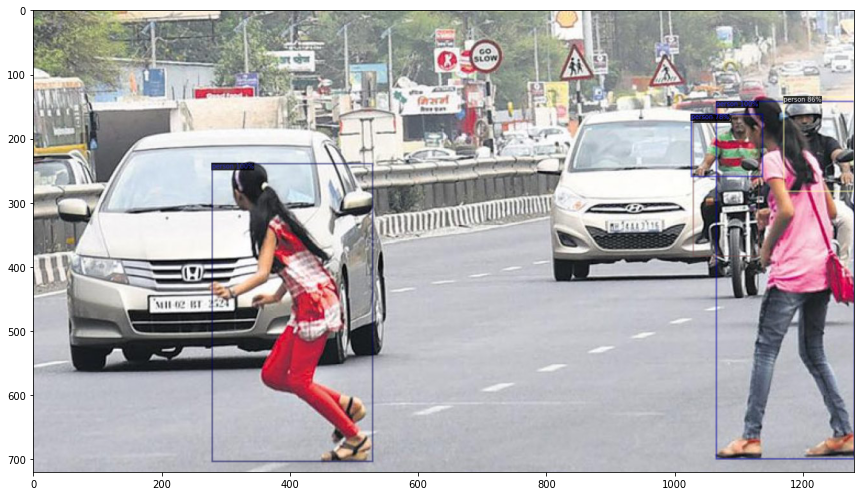

In [82]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(image_with_boxes)
plt.tight_layout()

# 2. cut part of the image from bounding boxes

In [ ]:
# based on: https://stackoverflow.com/questions/68008935/crop-image-using-pred-boxes-coordinates

### define function responsible for cropping part of an image defined by bounding box coordinates

In [68]:
def cropImageByBoundingBox(image, box):
    """
    Function responsible for cropping part of an image defined by bounding box coordinates

    :param: image: image to be processed
    :param: box: numpy array with four box coordinates

    return: cropped image object
    """

    x_top_left = box[0]
    y_top_left = box[1]
    x_bottom_right = box[2]
    y_bottom_right = box[3]

    if type(image) == np.ndarray:
        image = Image.fromarray(image)
    crop_img = image.crop((int(x_top_left), int(y_top_left), int(x_bottom_right), int(y_bottom_right)))

    if type(image) == Image.Image:
        crop_img = np.array(crop_img)

    return crop_img

### perform exemplary cropping

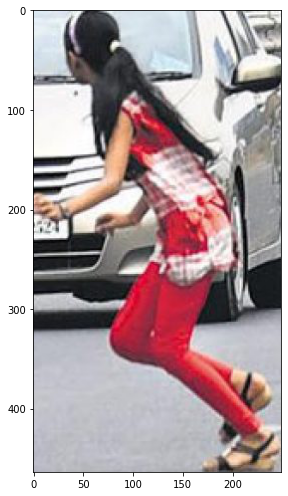

In [88]:
image_cropped = cropImageByBoundingBox(image, prediction_od_boxes[1])

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(image_cropped)
plt.tight_layout()

# 3. make individual skeletonization for each cropped image

### configure another detector (keypoint extraction)

In [89]:
cfg_kp = get_cfg()
cfg_kp.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg_kp.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

In [98]:
cfg_kp.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg_kp.MODEL.DEVICE = "cpu"
predictor_kp = DefaultPredictor(cfg_kp)

### make predictions

In [99]:
predictions_kp = predictor_kp(image_cropped)

/Users/michal/opt/anaconda3/envs/detectron2/lib/python3.8/site-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


### visualize results

In [100]:
viz_kp = Visualizer(image_cropped[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))

image_skeletonized = output_kp.get_image()[:, :, ::-1]

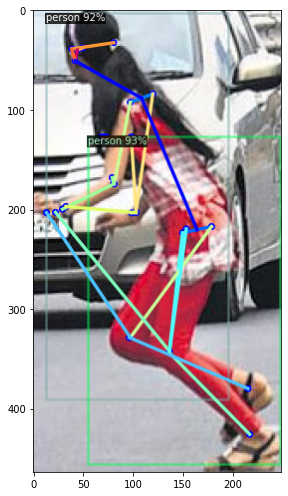

In [101]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(image_skeletonized)
plt.tight_layout()